In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# Dataset class definition
class AccidentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing and data augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CSV file path
csv_file = r"C:\Users\ime203\Desktop\Graduation\image_labels.csv"

# Load dataset
dataset = AccidentDataset(csv_file, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)



C:\Users\ime203\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ime203\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ime203/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 29.5MB/s]
Epoch 1/5 - Training: 100%|██████████████████████████████████████████████████████████| 374

Epoch [1/5], Loss: 0.9950, Train Accuracy: 0.6072


Epoch 1/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:30<00:00,  2.24s/it]


Epoch [1/5], Validation Loss: 0.9283, Validation Accuracy: 0.6156


Epoch 2/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [21:55<00:00,  3.52s/it]


Epoch [2/5], Loss: 0.8614, Train Accuracy: 0.6713


Epoch 2/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:36<00:00,  2.30s/it]


Epoch [2/5], Validation Loss: 0.8990, Validation Accuracy: 0.6353


Epoch 3/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [21:16<00:00,  3.41s/it]


Epoch [3/5], Loss: 0.8202, Train Accuracy: 0.7036


Epoch 3/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:36<00:00,  2.30s/it]


Epoch [3/5], Validation Loss: 0.8498, Validation Accuracy: 0.6915


Epoch 4/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [20:15<00:00,  3.25s/it]


Epoch [4/5], Loss: 0.7980, Train Accuracy: 0.7278


Epoch 4/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:38<00:00,  2.33s/it]


Epoch [4/5], Validation Loss: 0.8990, Validation Accuracy: 0.6879


Epoch 5/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [20:05<00:00,  3.22s/it]


Epoch [5/5], Loss: 0.7878, Train Accuracy: 0.7378


Epoch 5/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:17<00:00,  2.10s/it]


Epoch [5/5], Validation Loss: 0.7874, Validation Accuracy: 0.7367


Final Validation: 100%|████████████████████████████████████████████████████████████████| 94/94 [03:27<00:00,  2.21s/it]


Final Validation Accuracy: 0.7367012378721981
Final Precision: 0.7330401286246387
Final Recall: 0.7367012378721981
Final F1 Score: 0.7241045488823263


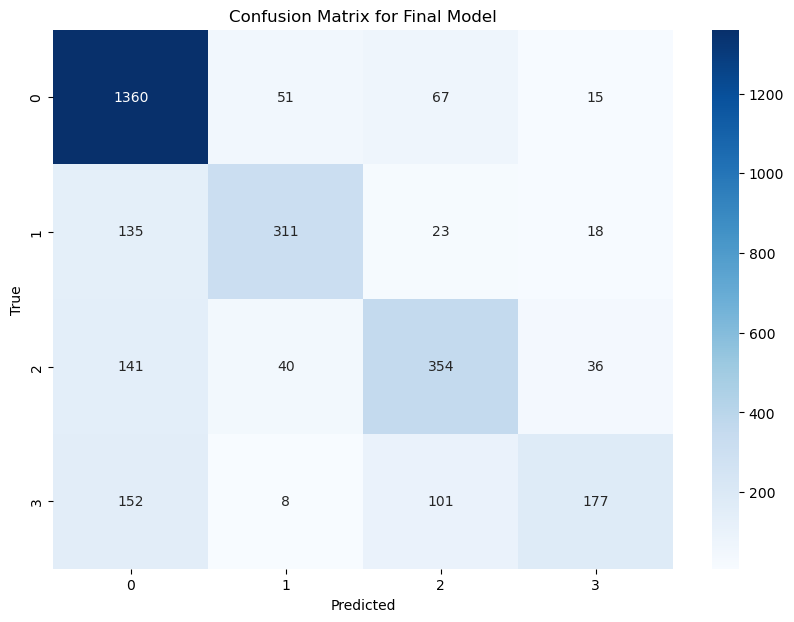

In [3]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm


# CNN+LSTM model definition using MobileNetV2
class CNNLSTMClassifierMobileNetV2(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, lstm_layers=2, lstm_dropout=0.5):
        super(CNNLSTMClassifierMobileNetV2, self).__init__()
        self.cnn = models.mobilenet_v2(pretrained=True)
        num_ftrs = self.cnn.classifier[1].in_features
        self.cnn.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, hidden_dim)
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 5:
            batch_size, seq_length, c, h, w = x.size()
            cnn_out = []
            for t in range(seq_length):
                cnn_out.append(self.cnn(x[:, t, :, :, :]))

            cnn_out = torch.stack(cnn_out, dim=1)
            lstm_out, _ = self.lstm(cnn_out)
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        elif len(x.shape) == 4:
            cnn_out = self.cnn(x)
            lstm_out, _ = self.lstm(cnn_out.unsqueeze(1))
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        else:
            raise ValueError("Unsupported input shape")

        return out

# Initialize the CNN+LSTM model using MobileNetV2
num_classes = 4
cnn_lstm_model = CNNLSTMClassifierMobileNetV2(num_classes=num_classes)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

# Training the CNN+LSTM model
num_epochs = 5
for epoch in range(num_epochs):
    cnn_lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        outputs = cnn_lstm_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    cnn_lstm_model.eval()
    val_running_loss = 0.0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            outputs = cnn_lstm_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.numpy())
            val_labels.extend(labels.numpy())

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_loss = val_running_loss / len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Final evaluation
cnn_lstm_model.eval()
val_predictions = []
val_labels = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation"):
        outputs = cnn_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.numpy())
        val_labels.extend(labels.numpy())

# Evaluate the final model
val_accuracy = accuracy_score(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)
prec = precision_score(val_labels, val_predictions, average='weighted')
rec = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

print(f'Final Validation Accuracy: {val_accuracy}')
print(f'Final Precision: {prec}')
print(f'Final Recall: {rec}')
print(f'Final F1 Score: {f1}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Final Model')
plt.show()